# OpenCl application walkthrough - Matrix Multiplication

Often it is helpful to see a complete example that is fully explained in every detail. Matrix multiplication is a commonly employed compute operation and we can use it for a complete example with OpenCL. The  multiplication of matrices **A** and **B** proceeds by taking the dot product between every row in **m** in matrix **A** and every column **n** of matrix **B**. If we multiply (elementwise) a row **m** of matrix **A** by a column **n** of Matrix B, then the dot product is the sum of the multiplied elements. The result of each dot product is then the value at position (m,n) in matrix **C**.

<figure style="margin-left:auto; margin-right:auto; width:80%;">
    <img style="vertical-align:middle" src="../images/matrix_multiplication.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Multiplying matrices A and B to get C.</figcaption>
</figure>


The strategy we use here is to associate a kernel with every point (m,n) in Matrix C. This means the Grid for this problem must be large enough to cover the entire size of Matrix C. Every kernel will compute its own dot product. The source code for the example is in [mat_mult.cpp](mat_mult.cpp). Click on the link and open up the file in a different window.

## Running the example program

We first run the application then understand how it works.

### Write out the matrices

The first step is to generate some matrices **A** and **B** for use by the program.

In [10]:
import numpy as np

from matplotlib import pyplot as plt

%matplotlib widget

# A is of size (NROWS_C, NCOLS_A)
# B is of size (NCOLS_A, NCOLS_C)    
# C is of size (NROWS_C, NCOLS_C)

NCOLS_A = 256
NROWS_C = 520
NCOLS_C = 1032

# Data type
dtype = np.float32

# Make up the arrays A, B, and C
A = np.random.random(size = (NROWS_C, NCOLS_A)).astype(dtype)
B = np.random.random(size = (NCOLS_A, NCOLS_C)).astype(dtype)

# Make up the answer
C = np.matmul(A, B, dtype = dtype)

# Write out the arrays as binary files
A.tofile("array_A.dat")
B.tofile("array_B.dat")
C.tofile("array_C_answer.dat")

### Run the program

In [11]:
!make clean; make; ./mat_mult.exe

rm -r *.exe
clang++ -framework OpenCL -std=c++11 -g -O2 -Xclang -fopenmp -I"./" -I../include -L"./" mat_mult.cpp\
		-o mat_mult.exe ""
	               name: Intel(R) Core(TM) i7-4850HQ CPU @ 2.30GHz 
	 global memory size: 17179 MB
	    max buffer size: 4294 MB
	     max local size: (1024,1,1)
Elapsed time is 0.471343seconds


### Read in the answer and verify results

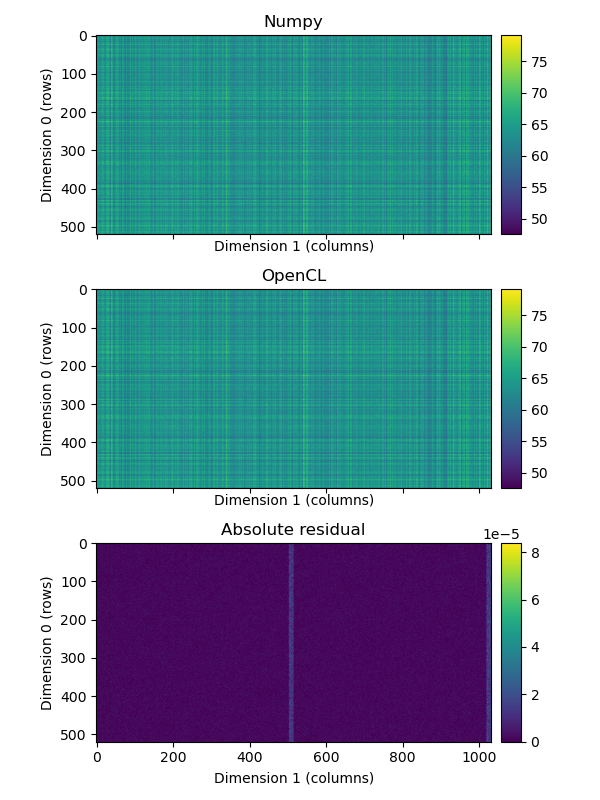

In [12]:
# Import axes machinery
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Read in the output from OpenCL
C_ocl = np.fromfile("array_C.dat", dtype=dtype).reshape((NROWS_C, NCOLS_C))

# Make plots
fig, axes = plt.subplots(3, 1, figsize=(6,8), sharex=True, sharey=True)

# Data to plot
data = [C, C_ocl, np.abs(C-C_ocl)]

# Labels to plot
labels = ["Numpy", "OpenCL", "Absolute residual"]

for n, value in enumerate(data):
    # Plot the graph
    ax = axes[n]
    im = ax.imshow(value)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    # Set labels on things
    ax.set_xlabel("Dimension 1 (columns)")
    ax.set_ylabel("Dimension 0 (rows)")
    ax.set_title(labels[n])

    # Put a color bar on the plot
    plt.colorbar(mappable=im, cax=cax)

fig.tight_layout()
plt.show()

## The example program - line by line

As covered in the Introduction, every accelerated application follows the same logical progression of steps: 

1. Compute devices discovered
1. Kernels prepared for compute devices
1. Memory allocated on the compute device
1. Memory copied to the compute device
1. Kernels run on the compute device
1. Wait for kernels to finish
1. Memory copied back from the computed device to the host
1. Repeat steps 3 - 8 as many times as necessary
1. Clean up resources and exit

We will now walk through every step in the sequence and explain how everything is working in as much depth as is practical. OpenCL applications have quite a fair bit of tedious boilerplate code, and just about every OpenCL application uses some form of home-grown header files to shield the programmer from extra complexity and another potential source of errors. The applications covered in this course are no different. We will explain what each helper function does and how it fits into the rest of the program. It is helpful to have the source code [mat_mult.cpp](mat_mult.cpp) open while we traverse the code.

### Header files

After some essential includes, we include our helper headers. In this instance the header **cl_helper.hpp** is located in the **course_material/include** directory. Open the file by clicking on this link to <a href="../include/cl_helper.hpp">cl_helper.hpp</a>.

```C++
// Bring in helper header to manage boilerplate code
#include "cl_helper.hpp"
```

The first thing that the header does is to include the headers for the OpenCL C library. If we open that file in the browser we see the code

```C++
#ifdef __APPLE__
    #include "OpenCL/opencl.h"
#else
    #include "CL/cl.hpp"
#endif
```

On MacOS, the header files for the OpenCL ICD loader are located in **OpenCL/opencl.h**, whereas on every other system they are in **CL/cl.hpp**. This is why we need a MacOS - specific **#ifdef**.

### Checking function calls with OpenCL

Every call to an OpenCL function has some way of validating wether or not it produced an error. The return code for each call is in the form of an OpenCL integer datatype **cl_int**, which guarantees a signed integer with exactly 32 bits. For more information on OpenCL datatypes click <a href="../L2_Survival_C++/OpenCL_datatypes.ipynb">here</a> or consult the the latest [OpenCL C specification](https://www.khronos.org/registry/OpenCL/specs/3.0-unified/pdf/OpenCL_C.pdf).

The standard defines a number of of error codes, **CL_SUCCESS** is the universal OpenCL code for a successful function call, and the **error_codes** std::map in **cl_helper.hpp** contains a C++ dictionary-like lookup table for error codes.

It is **always good practice** to always check the return code of each OpenCL call and adequately handle each return code. Otherwise OpenCL programs can fail silently and lead to undefined behaviour. The helper function **h_errchk** takes in an error code and a message and prints an error and exits if it encounters any error code other than **CL_SUCCESS**.

```C++
// Function to check error code
void h_errchk(cl_int errcode, const char *message) {
    if (errcode!=CL_SUCCESS) {
        // Is the error code in the map
        if (error_codes.count(errcode)>0) {
            std::printf("Error, Opencl call failed at \"%s\" with error code %s (%d)\n", 
                    message, error_codes[errcode], errcode);
        } else {
            // We don't know how to handle the error code, so just print it
            std::printf("Error, OpenCL call failed at \"%s\" with error code %d\n", 
                    message, errcode);
        }
        // We have failed one way or the other, so just exit
        exit(OCL_EXIT);
    }
};
```

Within the main program [mat_mul.cpp](mat_mul.cpp) we declare the variable **errorcode** to handle the output from programs.

```C++
// Useful for checking OpenCL errors
cl_int errcode;
```


### Resource discovery

Remember from the <a href="../L1_Introduction/L1 - Introduction.ipynb">Introduction</a> that **Buffers** are allocated within contexts and command queues need both contexts and devices. During the process of resource discovery, we need to: 

1. locate the platforms, 
2. find the devices in each platform
3. construct a context for every device found

It is most flexible and portable if we associate a single context with every device discovered. The following code defines some pointers that will point to allocations of platforms, devices, and contexts. It also defines some variables to store the number of platforms and devices. 

```C++
// Create handles to platforms, devices, and contexts
cl_uint num_platforms; // Number of platforms discovered
cl_uint num_devices;
cl_platform_id *platforms = NULL;
cl_device_id *devices = NULL;
cl_context *contexts = NULL;
```

The variable **target_device** decides which kind of devices we wish to use. Is is of type **cl_device_type** and there are three common choices:


| cl_device_type | explanation |  
| :- | :- | 
| CL_DEVICE_TYPE_ALL | get every OpenCL device
| CL_DEVICE_TYPE_GPU | get only GPU devices
| CL_DEVICE_TYPE_CPU | get only CPU devices

We choose the **CL_DEVICE_TYPE_ALL** type to get all possible OpenCL devices on the system.

A helper function called **h_acquire_devices** goes through this process and fills the contents of these variables.




```C++
// Helper function to acquire devices
h_acquire_devices(target_device,
                 &platforms,
                 &num_platforms,
                 &devices,
                 &num_devices,
                 &contexts);
```

### Examining h_acquire_devices in depth

We now examine **h_acquire_devices** in depth to 